In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from random import random

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

## 1. Data

## 1.1 Input Data

In [2]:
train_df = pd.read_csv("covid19-global-forecasting-week-1/train.csv",usecols=['Lat','Province/State','Country/Region','Date','ConfirmedCases','Fatalities'])
train_visual = train_df.copy()
train_df.head(2)

,Province/State,Country/Region,Lat,Date,ConfirmedCases,Fatalities
0,NaN,Afghanistan,33.0,2020-01-22,0.0,0.0
1,NaN,Afghanistan,33.0,2020-01-23,0.0,0.0


In [3]:
test_df = pd.read_csv("covid19-global-forecasting-week-1/test.csv", usecols=['Lat','Province/State','Country/Region','Date'])

### 1.2 Feature Engineering

I don't think that COVID has more chances to infect people in Kazakhstan than in US. Let's check number of cases of infection in different countries to confirm or refute my theory:

In [4]:
# replace NaN with a gap
train_df.fillna(' ', inplace=True)
train_df['Lat'] = train_df['Province/State'] + train_df['Country/Region']
train_df.drop('Province/State', axis=1, inplace=True)
train_df.drop('Country/Region', axis=1, inplace=True)
countries_list = train_df.Lat.unique()
df_countries = []
for i in countries_list:
    df_countries.append(train_df[train_df['Lat'] == i])
print("We have "+ str(len(df_countries))+" regions in our dataset")

We have 284 regions in our dataset


## 2. Data Visualization



In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17892 entries, 0 to 17891
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lat             17892 non-null  object 
 1   Date            17892 non-null  object 
 2   ConfirmedCases  17892 non-null  float64
 3   Fatalities      17892 non-null  float64
dtypes: float64(2), object(2)
memory usage: 559.2+ KB


In [6]:
train_df.describe()

,ConfirmedCases,Fatalities
count,17892.000000,17892.000000
mean,325.207523,11.974737
std,3538.599684,174.346267
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,10.000000,0.000000
max,69176.000000,6820.000000


Ok, now we have clear idea how the data works. I don't think that COVID has more chances to infect people in Kazakhstan than in US. Let's check number of cases of infection in different countries to confirm or reject my theory:

In [7]:
# num of infected in the country per day
def num_of_infected(country):
    num = train_visual.drop('Province/State', axis=1).where(train_visual['Country/Region'] == country)
    num = num.dropna()
    num = num.groupby('Date').sum().reset_index()
    num['Day'] = range(len(num))
    return num

# plot these cases
def plot_cases(df, ax, title):
    ax.plot(df['Day'], df['ConfirmedCases'], label='Confirmed Cases')
    ax.plot(df['Day'], df['Fatalities'], label='Fatalities')
    ax.set_title(title)
    ax.legend()

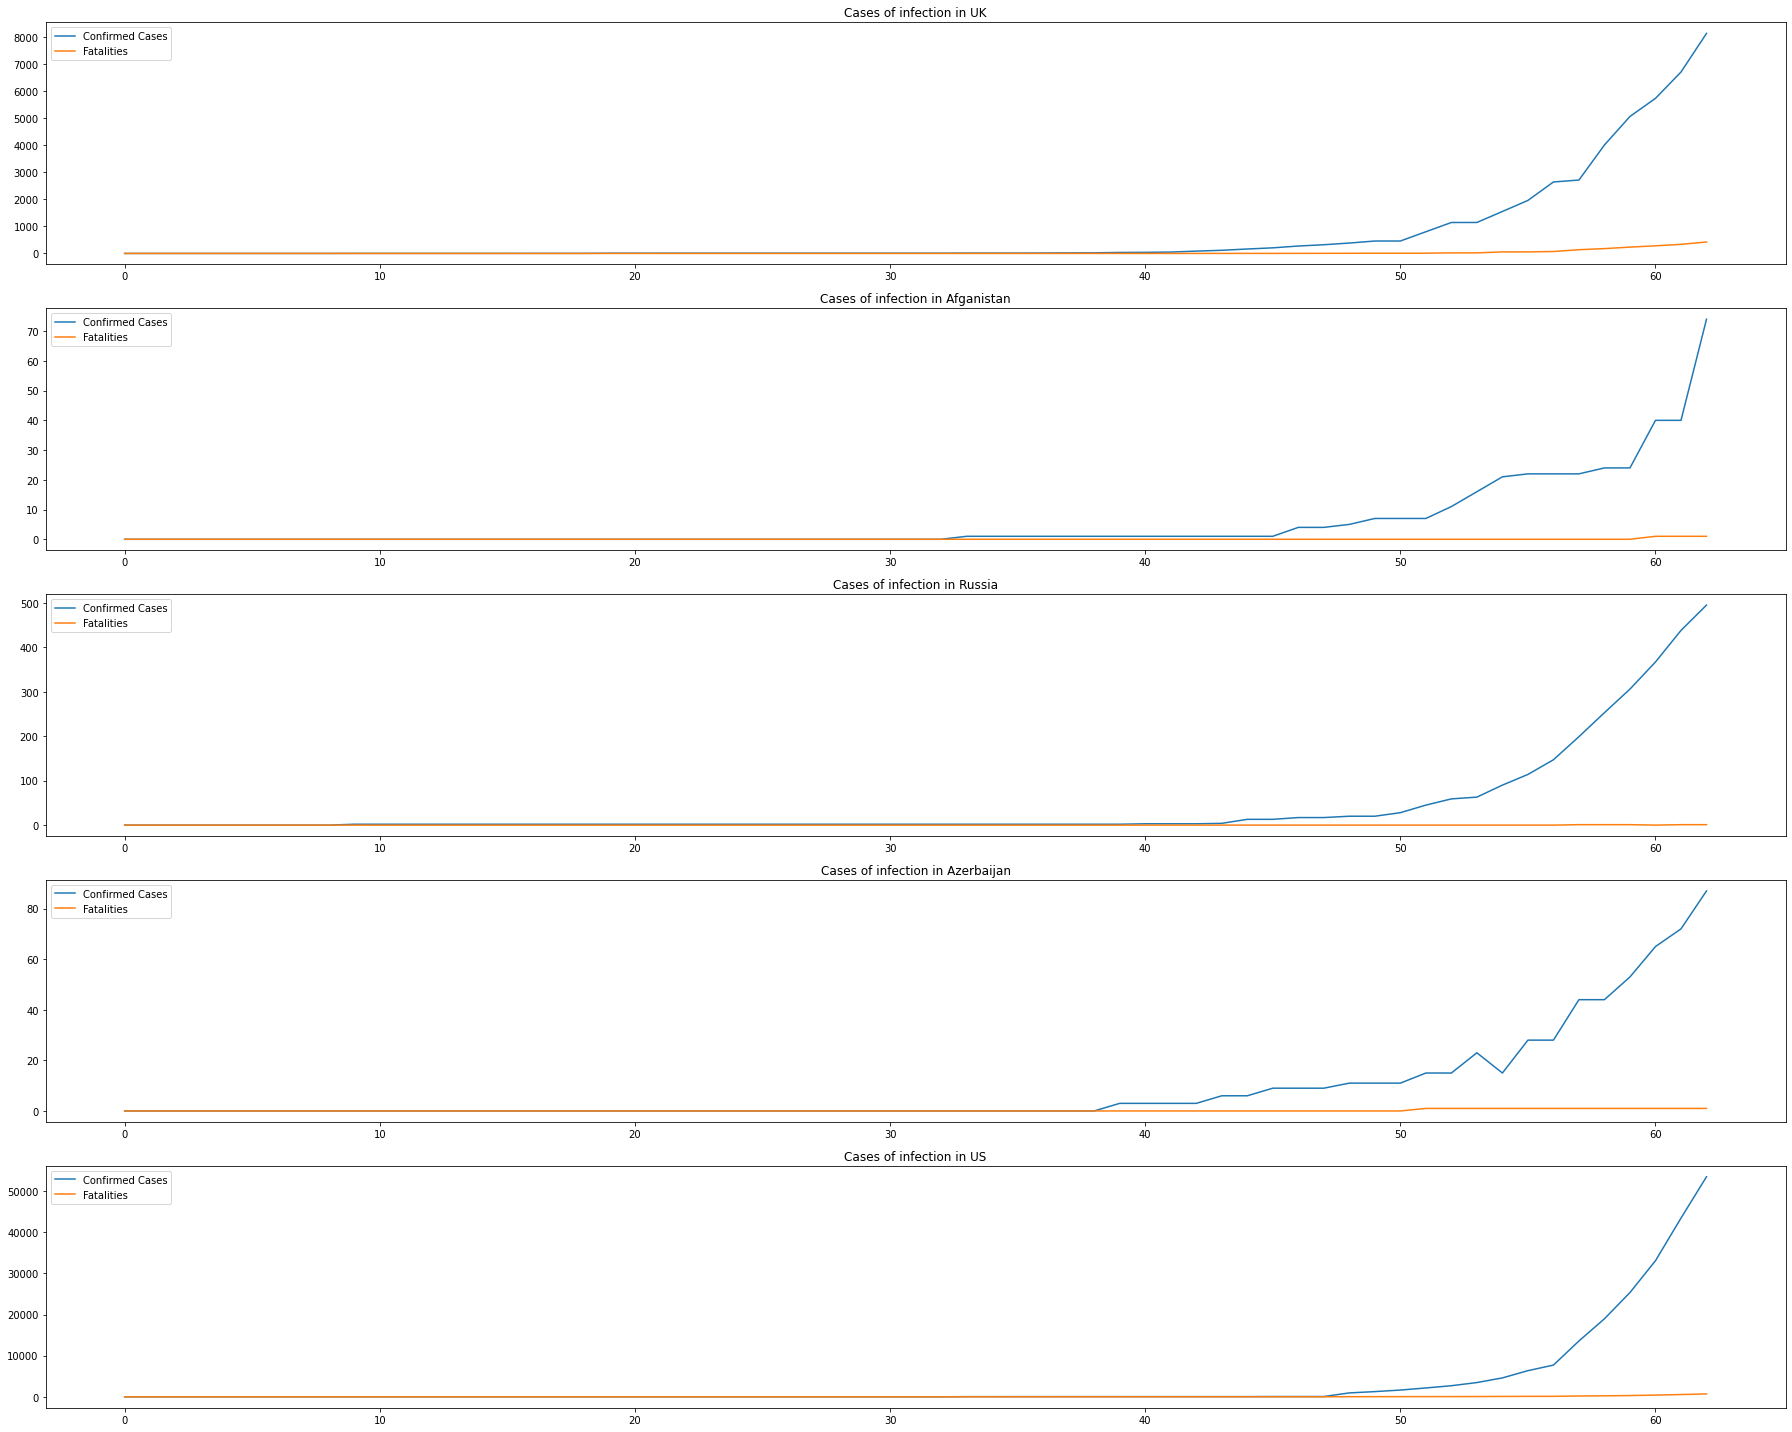

In [8]:
num_of_infected_uk = num_of_infected('United Kingdom')
num_of_infected_afg = num_of_infected('Afghanistan')
num_of_infected_rus = num_of_infected('Russia')
num_of_infected_az = num_of_infected('Azerbaijan')
num_of_infected_us = num_of_infected('US')

fig, ax = plt.subplots(5, 1, figsize=(25,20))

plot_cases(num_of_infected_uk, ax[0], 'Cases of infection in UK')
plot_cases(num_of_infected_afg, ax[1], 'Cases of infection in Afganistan')
plot_cases(num_of_infected_rus, ax[2], 'Cases of infection in Russia')
plot_cases(num_of_infected_az, ax[3], 'Cases of infection in Azerbaijan')
plot_cases(num_of_infected_us, ax[4], 'Cases of infection in US')

plt.tight_layout()
plt.show()

As we can see, the cases of infections in different countries have similar distribution: between 40th and 45th day. As a result, we don't need to know in which country we need to predict the future spread of the virus. For the final evaluation of the data for the subsequent construction of the model, I'll build decomposition graphs and conduct an ADF Test.

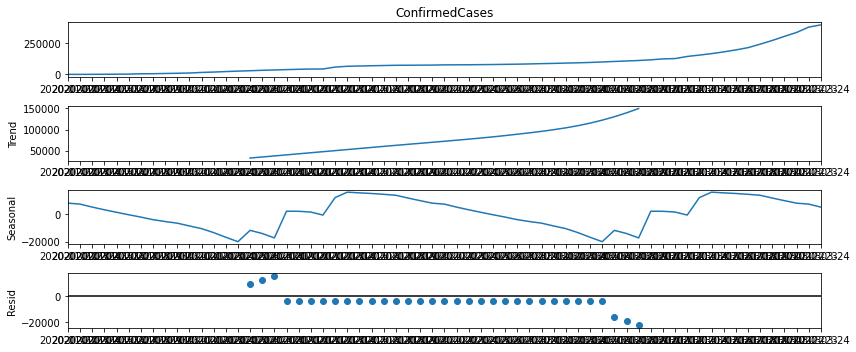

In [9]:
train_df['Date'] = pd.to_datetime(train_df['Date'])

plt.rcParams["figure.figsize"] = (12,5)
decompose_data = seasonal_decompose(train_visual.groupby('Date').sum()['ConfirmedCases'], model="additive", period=30)
decompose_data.plot();

In [10]:
dftest = adfuller(train_df.ConfirmedCases, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -15.641158833687815
2. P-Value :  1.6396353370286159e-28
3. Num Of Lags :  41
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 17850
5. Critical Values :
	 1% :  -3.430716400035936
	 5% :  -2.8617019348641204
	 10% :  -2.566856193690025


Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can not be rejected. Hence, the series is non-stationary. Well, now we can say with confidence that we will use the SARIMAX model.

# 3.Build Model

In [11]:
# submissions
submit_confirmed=[]
submit_fatal=[]
for i in df_countries:
    # confirmed cases
    data = i.ConfirmedCases.astype('int32').tolist()
    # build and fit model
    model = SARIMAX(data, order=(2,1,0), seasonal_order=(1,1,0,12))
    # without notifications
    model_fit = model.fit(disp=False)
    # make prediction for next 34 days
    predicted = model_fit.predict(len(data), len(data)+34)
    new = np.concatenate((np.array(data), np.array([int(num) for num in predicted])), axis=0)
    # add submission for last 43 days 
    submit_confirmed.extend(list(new[-43:]))
    
    # fatalities cases
    data = i.Fatalities.astype('int32').tolist()
    # build and fit model
    model = SARIMAX(data, order=(2,1,0), seasonal_order=(1,1,0,12))
    # without notifications
    model_fit = model.fit(disp=False)
    # make prediction for next 34 days
    predicted = model_fit.predict(len(data), len(data)+34)
    new=np.concatenate((np.array(data), np.array([int(num) for num in predicted])),axis=0)
    # add submission for last 43 days 
    submit_fatal.extend(list(new[-43:]))

# concatenate Id, confirmed and fatalities cases
df_submit = pd.concat([pd.Series(np.arange(1, 1 + len(submit_confirmed))),pd.Series(submit_confirmed), pd.Series(submit_fatal)], axis=1)

# 4.Submission

### 4.1. Submit

In [12]:
#df_submit.interpolate(method='pad', xis=0, inplace=True)
df_submit = df_submit.fillna(method='pad').astype(int)
df_submit.to_csv('submission.csv', header=['ForecastId','ConfirmedCases','Fatalities'],index=False)

### 4.2. Visualisation of Predictions

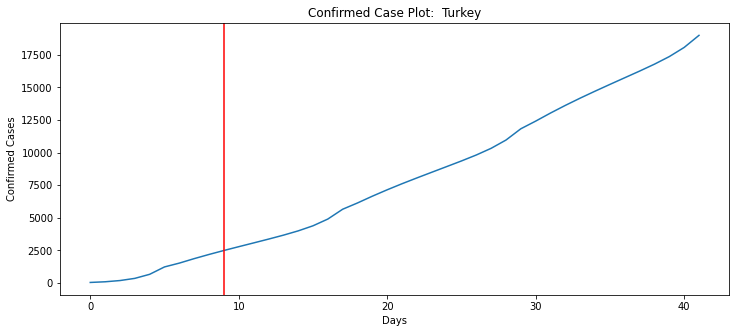

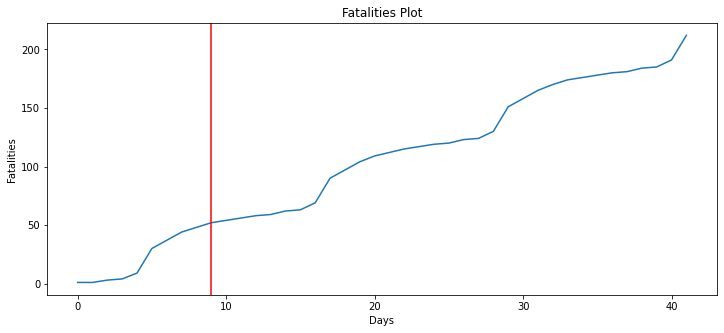

In [13]:
# contrived dataset
n=213 # select country
data = df_countries[n].ConfirmedCases.astype('int32').tolist()
# fit model
new=submit_confirmed[9159:9201]
plt.plot(new)
plt.axvline(x=9,color='r')
plt.title("Confirmed Case Plot: "+str(df_countries[n].iloc[0,0]))
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.show()


# contrived dataset
data = df_countries[n].Fatalities.astype('int32').tolist()
new=submit_fatal[9159:9201]
plt.plot(new)
plt.axvline(x=9,color='r')
plt.title("Fatalities Plot")
plt.xlabel('Days')
plt.ylabel('Fatalities')
plt.show()

# Score: 1.07562